# 題目1：使用 NumPy 從零實現邏輯迴歸

In [1]:
# dataset from https://github.com/manthanpatel98/Restaurant-Review-Sentiment-Analysis/tree/master
!curl -L -o restaurant_reviews.csv \
  "https://raw.githubusercontent.com/manthanpatel98/Restaurant-Review-Sentiment-Analysis/master/Restaurant%20reviews.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3510k  100 3510k    0     0  8070k      0 --:--:-- --:--:-- --:--:-- 8164k


In [2]:
import csv
from collections import OrderedDict
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# vectorizer
class CountVectorizer:
    # initializes with array of strings
    def __init__(self, dataset):
        self._vocabulary = OrderedDict()
        for dp in dataset:
            tokens = self._tokenize(dp)
            for token in tokens:
                if token not in self._vocabulary:
                    self._vocabulary[token] = len(self._vocabulary) # fill out indexed vocabulary

    # input: string -> output: list of tokens
    def _tokenize(self, s):
        s = s.lower()
        return re.compile(r"\b\w+\b").findall(s)

    # input: string -> output: vector
    def transform(self, s):
        s = s.lower()
        vec = np.zeros(len(self._vocabulary),)
        for token in self._tokenize(s):
            idx = self._vocabulary.get(token)
            if idx is not None:
                vec[idx] += 1
            else:
                print("string not recognized")
                return np.array([])
        return vec

In [29]:
# logistic regression
class LogisticRegressor:
    def __init__(self, xs, ys, percent_training=0.8):
        self._rng = np.random.default_rng(seed=42)
        
        # split training and testing data
        n_samples = len(xs)
        n_train = int(n_samples * percent_training)
        self._xs_train = xs[:n_train]
        self._xs_test = xs[n_train:]
        self._ys_train = ys[:n_train]
        self._ys_test = ys[n_train:]
        # initialize perceptron
        self._W = self._rng.uniform(-0.1, 0.1, size=len(xs[0]))
        self._b = self._rng.uniform(-0.1, 0.1)

    def train(self, epochs, learning_rate=0.1):
        loss_train_history = []
        loss_test_history = []
        accuracy_test_history = []
        for epoch in range(epochs):
            epoch_losses = self._propagate_training_set(learning_rate)
            test_losses, accuracy = self.test()
            loss_train_history.append(np.mean(epoch_losses))
            loss_test_history.append(np.mean(test_losses))
            accuracy_test_history.append(accuracy)
        return (loss_train_history, loss_test_history, accuracy_test_history)

    def test(self):
        losses = []
        correct = 0
        for X, y in zip(self._xs_test, self._ys_test):
            y_predicted = self._forward_propagate(X)
            classification = 1 if y_predicted >= 0.5 else 0
            loss = self._bce_loss(y, y_predicted)
            losses.append(loss)
            if classification == y:
                correct += 1
        return (losses, correct / len(self._xs_test))
        
    # model use
    def classify(self, X):
        return 1 if self._forward_propagate(X) >= 0.5 else 0

    def _propagate_training_set(self, learning_rate):
        xids = np.random.permutation(len(self._xs_train)) # shuffle to mitigate bias
        losses = []
        
        for xid in xids: # run through full data set once
            loss = self._propagate(self._xs_train[xid], self._ys_train[xid], learning_rate)
            losses.append(loss)
        return losses

    def _propagate(self, X, y, learning_rate):
        y_predicted = self._forward_propagate(X)
        dW, db = self._backpropagate(X, y, y_predicted)
        self._W -= dW * learning_rate
        self._b -= db * learning_rate
        return self._bce_loss(y, y_predicted)

    def _forward_propagate(self, X):
        return self._sigmoid(np.dot(self._W, X) + self._b)

    def _backpropagate(self, X, y, y_predicted):
        # math kept here for derivation purposes
        # dJ_dy = (y_predicted - y) / (y_predicted * (1 - y_predicted)) # partial of loss with respect to activation
        # dy_dA = y_predicted * (1 - y_predicted) # partial of activation with respect to linearly transformed output
        # dA_dW = X # partial of weights and bias with respect to linearly transformed output
        # dA_db = 1
        # # chain rule
        # dJ_dW = dJ_dy * dy_dA * dA_dW
        # dJ_db = dJ_dy * dy_dA * dA_db
        dJ_dW = (y_predicted - y) * X
        dJ_db = y_predicted - y
        return (dJ_dW, dJ_db)
            
    # sigmoid function
    def _sigmoid(self, X):
        X = np.clip(X, -500, 500) # prevents overflow
        return 1 / (1 + np.exp(-X))

    # binary cross entropy
    def _bce_loss(self, y, y_predicted, eps=1e-15):
        y_predicted = np.clip(y_predicted, eps, 1 - eps)
        return -(y * np.log(y_predicted) + (1 - y) * np.log(1 - y_predicted))


In [27]:
# functions for cleaning data
def read_data():
    reviews = []
    sentiments = []
    with open('restaurant_reviews.csv') as csv_file:
        reader = csv.reader(csv_file)
        header = next(reader)
        for row in reader:
            review = row[2]
            rating = row[3]
            try:
                sentiments.append(1 if float(rating) >= 2.5 else 0)
                reviews.append(review)
            except ValueError:
                if row[3].lower() == "like":
                    sentiments.append(1)
                    reviews.append(review)
    return (reviews, sentiments)
reviews, sentiments = read_data()

In [30]:
count_vectorizer = CountVectorizer(reviews)

# format x and y data
xs = []
ys = sentiments
for review in reviews:
    xs.append(count_vectorizer.transform(review))
xs = np.array(xs)
ys = np.array(ys)

regressor = LogisticRegressor(xs, ys, 0.8)
train_loss_history, test_loss_history, accuracy_history = regressor.train(10, 0.01)

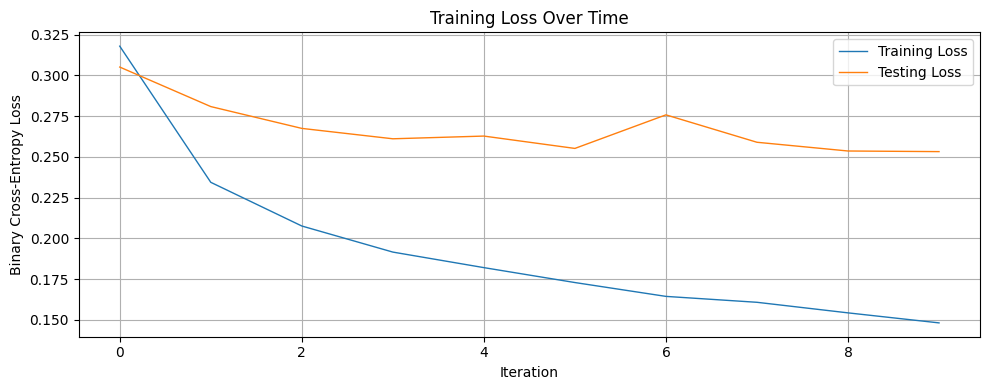

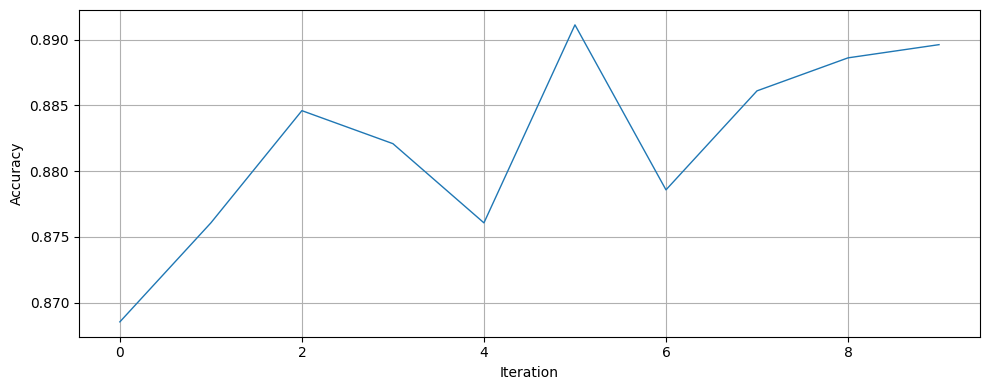

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss_history, label='Training Loss', linewidth=1)
plt.plot(test_loss_history, label='Testing Loss', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10, 4))
plt.plot(accuracy_history, linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()

plt.show()

In [33]:
print(regressor.classify(count_vectorizer.transform("the food is extremely delicious and yummy, 10/10 would have again!")))
print(regressor.classify(count_vectorizer.transform("disgusted, horrible time, do not come here.")))

1
0


# 題目2：Klook產品推薦語的初步個人化生成

## Generating Targeted Promotional Material

When generating targeted promotional material with general-use LLMs, we should clearly state:
1. Instruction, to inform the model of the desired task, including limitations consistent throughout the prompts, requirements, or tones.
2. Language, so we can pass the user's system/app language to the LLM and no intermediary translation is needed.
3. Target user tags, so the tone and content resonate with the intended audience.
4. Product name/tags, so the model can accurately sell the product.
5. Promotions, to drive urgency.

I used GPT-3.5-turbo with parameters adjusted to:
* Temperature: 1
* Maximum length: 128
* Top p: 0.85
* Frequency penalty: 0
* Presence penalty: 0.6

In order to ensure the LLM understood the expected output, I used one-shot prompting by including an example of expected output for a given input. This ensures the LLM understands that a one-line response is expected, and allows me to use the result directly without needing to extract the needed material. Additionally, with testing, it seemed to generate both Chinese and English correctly out-of-the-box. 

### Example Prompt

#### System Prompt
```
Generate one targeted promotional sentence of no more than 20 words or 20 Chinese characters (depending on the language) including punctuation, based on the following information. Make sure the sentence includes at least one concrete product feature and uses language that emotionally resonates with the target user tag. Do not include the product name or promotion directly as it is redundant. The material should drive user engagement. Follow the character limit exactly, do not go over. An example is given:
Q:
Language: English
Target user tags: Family Travel, Budget Travel, Couple Travel, Technology
Product name: Disney Land Hong Kong tickets
Product tags: Amusement Park, Family-friendly
Promotions: 5% off from August 12-18
A:
A great place to take your kids for budget-friendly family adventure!
```

#### User Prompt
```
Q:
Language: <lang>
Target user tags: <user_tag1>, <...>
Product name: <product_name>
Product tags: <product_tag1>, <...>
Promotions: <promos>

A:
```

## Issues with LLM Generation

When experimenting with my prompt, one issue was when the user's tags conflict, the LLM may generate conflicting responses. An example prompt using the given system prompt is shown:

```
Q:
Language: English
Target user tags: Budget, Luxury, Relaxing
Product name: Four Seasons Hotel
Product tags: Luxury, Hotel, Resort
Promotions: None
A:
```

This prompt generates the output

```
Indulge in lavish comfort without breaking the bank for a truly luxurious escape.
```

This material is clearly contradictory, mentioning budgetary constrains as well as luxury. The issue is that some of the user's tags are contradictory and/or doesn't match the product, but the LLM tries to include it in the material anyways. I propose pre-filtering user tags with a compatibility map. 

### Compatibility Mapping as a Solution

By building a compatibility map from user tags to product tags, user tags can be pre-filtered to only include compatible tags. Some pseudocode is provided.

```
compatibility_map = {
    "Budget": ["Student", "Backpacking"],
    "Resort": ["Luxury", "Relaxing"]
}
valid_user_tags = set()
for pt in product_tags:
    compatible = compatibility_map.get(pt, [])
    for c in compatible:
        if c in user_tags:
            valid_user_tags.add(c)

message = generate_promo_material(valid_user_tags) // use just the valid user tags instead of all of them
```

This solution is simple and effective, since compatibilities can be curated to not include contradictions. Given a finite number of tags, compatibilities can be bootstrapped with LLM assistance to reduce manual workload and then curated manually for safety. Or, a pre-pass LLM command asking to extract relevant tags before the material generation. Additionally, with little change to core functionality, tag compatibility can be generated dynamically by comparing embeddings to find semantic similarity, or with user interaction data to find commonly associated tags. 